In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.style.use('default')

In [4]:
from src.post_p_large_ensemble import run_seasonal_qdm

In [87]:
era2cmip = {
    't2m': 'tas',
    't2m_max': 'tasmax',
    't2m_min': 'tasmin',
    'tp': 'pr',
    'huss': 'huss',  # Specific humidity does not exist in ERA, so just mapping CMIP to CMIP
    # 'd2m': 'tdps',
    'ws': 'sfcWind',
    'sm': 'mrsos'  # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2020GL089991
}

cmip2era = {v: k for k, v in era2cmip.items()}

regions_dict = {
    'USeast': {'lat': 41.3, 'lon': -72.5},
    'USwest':  {'lat': 37.7, 'lon': -122.4, },
    'iceland':  {'lat': 65, 'lon': -19},
    'europe':  {'lat': 51, 'lon': 10.5},
    'australia': {'lat': -25.2, 'lon': 133.7},
    'tropics': {'lat': 3.9, 'lon': -53.1}
}

variable = 'tasmax'

models_for_vars = {
    'tas': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR', 'EC-Earth3'],
    'pr': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR'],
    'tasmax': ['CanESM5', 'cesm_lens', 'MIROC6', 'MPI-ESM1-2-LR', 'EC-Earth3'],
}
# ,['USwest', 'europe', 'australia', 'tropics', 'USeast', 'iceland']:
region  ='tropics'
lat = regions_dict[region]['lat']
lon = regions_dict[region]['lon']
print(f'Processing {region} future for {variable}')


path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/{region}/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(path, consolidated=True).load()

if variable in ('tasmax', 'tas'):
    reanalysis_daily[cmip2era[variable]] += 273.15

Processing tropics future for tasmax


In [113]:
reanalysis_daily

<xarray.Dataset>
Dimensions:  (time: 14975)
Coordinates:
    lat      float32 4.0
    lon      float32 -53.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    t2m      (time) float32 23.02 24.13 24.67 24.69 ... 26.63 26.36 25.17 25.42
    t2m_max  (time) float32 299.9 304.8 304.3 301.7 ... 304.0 303.2 302.3 303.3
    tp       (time) float32 11.91 8.977 5.842 2.114 ... 1.606 1.712 6.179 0.2

In [88]:
tropics = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'], variable, 'day', 
                               lat=regions_dict[region]['lat'], lon=regions_dict[region]['lon'],
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [ ]:
print('Processing historical models')
large_ens_hist = run_seasonal_qdm(
    tropics.hist_dsets['cesm_lens'],
    tropics.hist_dsets['cesm_lens'],
    reanalysis_daily[cmip2era[variable]]
)

In [ ]:
def select_months(
    data: xr.DataArray, monthly_win
) -> xr.DataArray:
    return data.sel(time=data.time.dt.month.isin(monthly_win))

In [ ]:
obs_r = obs.where(obs.time == hist.time)
hist_r = hist.where(obs.time == hist.time)

In [18]:
from src.post_p_large_ensemble import implement_quantile_delta_mapping, qdm_large_ensemble
from math import floor


In [10]:
monthly_window = np.roll(months, -month + floor(
            monthly_w / 2) + 1)[:monthly_w]

hist_s = select_months(hist, monthly_window)
obs_s = select_months(obs, monthly_window)
X_s = select_months(X, monthly_window)

NameError: name 'months' is not defined

In [ ]:
window_qdm = implement_quantile_delta_mapping(X_s, hist_s, obs_s)

In [99]:
reanalysis_daily[cmip2era[variable]]

<xarray.DataArray 't2m_max' (time: 14975)>
array([299.93848, 304.83893, 304.33804, ..., 303.17102, 302.3016 ,
       303.2958 ], dtype=float32)
Coordinates:
    lat      float32 4.0
    lon      float32 -53.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31

In [119]:
tropics.future_dsets['MIROC6']

<xarray.DataArray 'tasmax' (member_id: 50, time: 31411, lat: 1, lon: 1)>
array([[[[306.14948746]],

        [[305.14732738]],

        [[305.65551806]],

        ...,

        [[309.70359273]],

        [[309.4581007 ]],

        [[309.63187971]]],


       [[[304.526603  ]],

        [[304.78661043]],

        [[305.28317005]],
...
        [[307.51057858]],

        [[308.02430233]],

        [[308.32396465]]],


       [[[304.91296213]],

        [[303.65385444]],

        [[303.48115399]],

        ...,

        [[307.8650665 ]],

        [[307.96740937]],

        [[307.97835889]]]])
Coordinates:
  * lat        (lat) float64 5.0
  * lon        (lon) float64 0.0
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2100-12-31
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Maximum Near-Surface Air Temperature
    original_name:  T2
    standard_name:  air_temperature
    units:          K

In [93]:
obs =  reanalysis_daily[cmip2era[variable]]

large_ens_hist = qdm_large_ensemble(
    tropics.hist_dsets,
    tropics.hist_dsets,
    obs.load(),
    monthly_w = 3,
)

CanESM5 has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
cesm_lens has been post-processed


In [94]:
obs =  reanalysis_daily[cmip2era[variable]]


large_ens_future = qdm_large_ensemble(
    tropics.future_dsets,
    tropics.hist_dsets,
    obs.load(),
    monthly_w = 3,
)

CanESM5 has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
cesm_lens has been post-processed


In [ ]:
moedl = 'CanESM5'
large_ens_future[model].sel(member_id=1).plot()
large_ens_hist[model].sel(member_id=1).plot()

#tropics.hist_dsets[model].sel(member_id=1).plot()
#obs.sel(time=slice('1970', '2015')).plot()

In [22]:
tropics.hist_dsets.keys()

dict_keys(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'])

In [102]:
for model in list(tropics.hist_dsets.keys()):
    large_ens_hist[model] -= 273
    large_ens_future[model]  -= 273

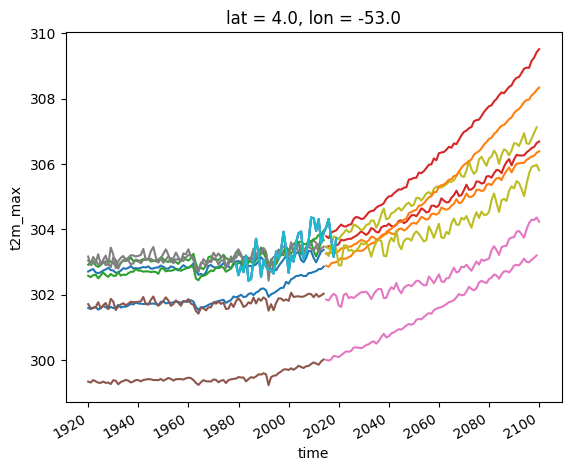

In [103]:
for model in list(tropics.hist_dsets.keys()):

    tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
    tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

    (large_ens_hist[model]).resample(time='AS').mean().mean('member_id').plot()
    (large_ens_future[model]).resample(time='AS').mean().mean('member_id').plot()

    (obs-273).resample(time='AS').mean().plot()

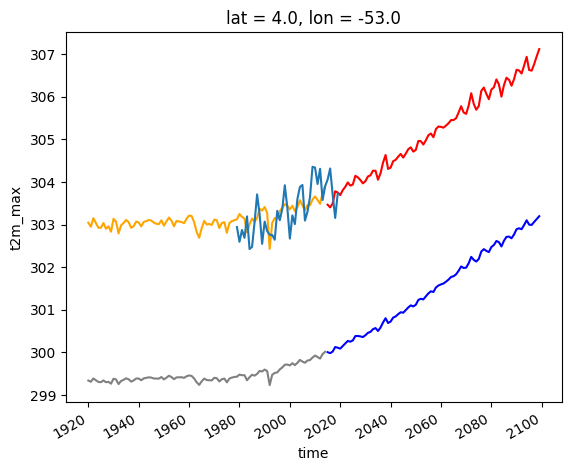

In [105]:
model = 'cesm_lens'

tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='gray')
tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='blue')

large_ens_hist[model].resample(time='AS').mean().mean('member_id').plot(color='orange')
large_ens_future[model].resample(time='AS').mean().mean('member_id').plot(color='red')

(obs-273).resample(time='AS').mean().plot()

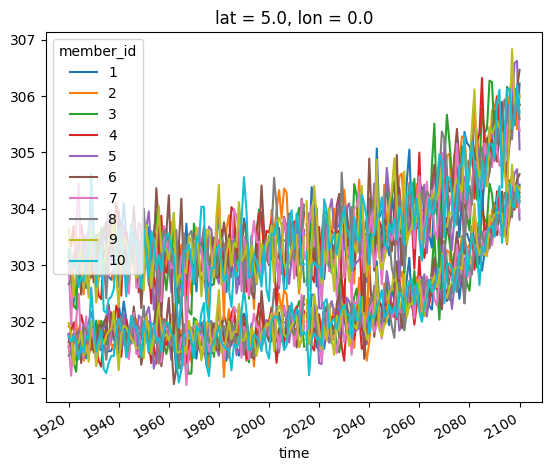

In [107]:
model = 'MPI-ESM1-2-LR'

tropics.hist_dsets[model].resample(time='AS').mean().plot(hue='member_id')
tropics.future_dsets[model].resample(time='AS').mean().plot(hue='member_id')

large_ens_hist[model].resample(time='AS').mean().plot(hue='member_id')
large_ens_future[model].resample(time='AS').mean().plot(hue='member_id')

#obs.resample(time='AS').mean().plot()

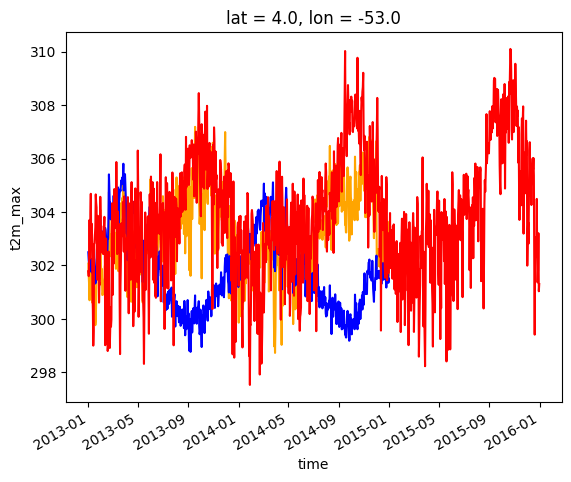

In [117]:
model = 'MPI-ESM1-2-LR'
year = slice('2013','2015')
large_ens_hist[model].sel(time=year,  member_id=1).plot(color='orange')

tropics.hist_dsets[model].sel(time=year, member_id=1).plot(color='blue')

(obs-273).sel(time=year).plot(color='red')

In [71]:
obs =  reanalysis_daily[cmip2era[variable]]*(997/(1000*24*60*60))

model = 'MPI-ESM1-2-LR'

large_ens_future_1 = qdm_large_ensemble(
    tropics.future_dsets[model],
    tropics.hist_dsets[model],
    obs.load(),
    monthly_w = 3,
)

In [70]:
large_ens_hist_1 = qdm_large_ensemble(
    tropics.hist_dsets[model],
    tropics.hist_dsets[model],
    obs.load(),
    monthly_w = 3,
)

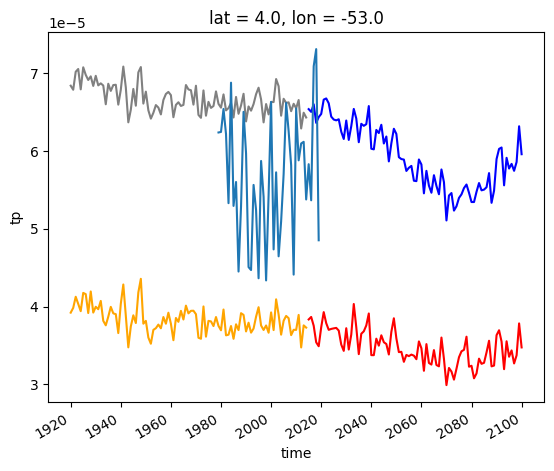

In [80]:
model = 'MPI-ESM1-2-LR'

tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='gray')
tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot(color='blue')

large_ens_hist_1.resample(time='AS').mean().mean('member_id').plot(color='orange')
large_ens_future_1.resample(time='AS').mean().mean('member_id').plot(color='red')

obs.resample(time='AS').mean().plot()

In [ ]:
tropics.hist_dsets[model].mean('member_id').values


In [ ]:
tropics.hist_dsets[model].sel(member_id=1)

In [ ]:
sns.kdeplot(tropics.hist_dsets[model].sel(member_id=1).values.flatten())


In [ ]:
sns.kdeplot(tropics.hist_dsets[model].values.flatten(), cumulative =True)
sns.kdeplot(large_ens_hist.values.flatten(), cumulative =True)
sns.kdeplot(obs_r, cumulative =True)

In [ ]:
sns.kdeplot(tropics.hist_dsets[model].values.flatten(), cumulative =True)

sns.kdeplot(tropics.future_dsets[model].values.flatten(), cumulative =True)
sns.kdeplot(large_ens_hist.values.flatten(), cumulative =True)
sns.kdeplot(large_ens_future.values.flatten(), cumulative =True)

sns.kdeplot(obs_r, cumulative =True)

In [ ]:
model = 'MIROC6'

tropics.hist_dsets[model].resample(time='AS').mean().mean('member_id').plot()
tropics.future_dsets[model].resample(time='AS').mean().mean('member_id').plot()

large_ens_hist.resample(time='AS').mean().mean('member_id').plot()
large_ens_future.resample(time='AS').mean().mean('member_id').plot()

obs_r.resample(time='AS').mean().plot()

In [ ]:
model = 'MIROC6'
large_ens_hist.resample(time='1M').mean().sel(member_id=1).plot()
large_ens_future.resample(time='1M').mean().sel(member_id=1).plot()

tropics.hist_dsets[model].resample(time='1M').mean().sel(member_id=1).plot()
tropics.future_dsets[model].resample(time='1M').mean().sel(member_id=1).plot()

obs_r.resample(time='1M').mean().plot()

In [ ]:
model = 'MIROC6'
large_ens_hist.rolling(time=365*10).mean().sel(member_id=1).plot()
large_ens_future.rolling(time=365*10).mean().sel(member_id=1).plot()

tropics.hist_dsets[model].rolling(time=365*10).mean().sel(member_id=1).plot()
tropics.future_dsets[model].rolling(time=365*10).mean().sel(member_id=1).plot()

obs_r.rolling(time=365*10).mean().plot()